# MiniProject#1
안녕하세요, 딥러닝 조교 한창완입니다. 본 자료는 딥러닝 실습 수업을 위해 제작된 것입니다.

파이썬 문법
- 점프투파이썬(https://wikidocs.net/book/1 ) 참고

이번 과제는 Convolutional Neural Network를 이용하여 Classification을 해보는 것입니다.


##  Pet 분류기
만들어볼 모델은 개와 고양이의 종을 분류하는 모델입니다.
반려동물에는 많은 종이 있지만 그중에서 25가지종을 분류해보겠습니다.

keras에서 이미지의 train set을 생성하는 방법은 ImageDataGenerator모듈의 flow_from_directory를 사용하여 불러오는 방법이 있습니다. 저희의 실습환경은 구글 Colab이기 때문에, 위의 방법은 효율적이지 못합니다.


※flow_from_directory은 사진을 한장씩 읽어서, 데이터셋을 만드는데 구글 colab은 이러한 방식이 매우 오래걸립니다. 또한 Google 드라이브에 올리는 것 역시 오래 걸립니다.

그래서 numpy형태로 저장해둔  train set을 사용하여 실습 및 미니프로젝트를 진행하겠습니다. 

##1.먼저 구글드라이브와 colab을 연동해봅시다.
- step 1: 구글드라이브의 '**내 드라이브**' 아래에 '**Pet**' 이라는 이름의 폴더를 만들어보세요.
- step 2: 이 프로젝트를 해당 경로에 놓고, 올려드린 **imageData_25.npy, imageDataLabel.npy**를 업로드 해서 넣어주세요.(약 2분정도 소요됩니다.)
- step 3: 다 되었다면 아래처럼 폴더에 파일이 있을겁니다.

내 드라이브

L Pet
> L MiniProject#1.ipynb

> L imageData_25.npy

> L imageDataLabel_25.npy


- step 4: 이제 구글드라이브와 colab을 연동하겠습니다. 아래의 코드를 실행해주세요. 링크하나와 authorization code 또는 새로운 창이 나올겁니다.
[참고링크](https://somjang.tistory.com/entry/Google-Colab%EC%97%90%EC%84%9C-Google-Drive%EC%99%80-%EC%97%B0%EB%8F%99%ED%95%98%EA%B8%B0)

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
import os
if os.getcwd() != '/content/drive/My Drive':
    os.chdir('./drive/My Drive')

    Mounted at /content/drive/ 
라는 문구가 나왔다면 성공입니다.아래의 명령어를 실행하여

    /content/drive/My Drive
이 나왔는지 확인해주세요

In [ ]:
!pwd

## 2.train set으로 이미지와 이름확인하기

일단 train set을 모두 가져옵니다.

In [ ]:
import numpy as np
import tensorflow as tf

train_images = np.load("./Pet/imageData_25.npy", allow_pickle=True)
train_labels = np.load("./Pet/imageDataLabel_25.npy", allow_pickle=True)

이제 가져온 train set을 확인해봅시다. 

In [ ]:
import matplotlib.pyplot as plt

def draw_Pet(train_images, train_labels,image_offset =1000):
  data_size = train_images.shape[0]
  if image_offset>= data_size-4:
    image_offset =data_size-4
  fig = plt.figure()
  fig.set_size_inches(10, 10, forward=True)
  rows=2
  cols=2
  
  for i in range(4):
    ax = fig.add_subplot(rows,cols,i+1)
    ax.imshow(train_images[image_offset+i])
    ax.set_title(train_labels[image_offset+i])
    ax.axis("off")

draw_Pet(train_images, train_labels,image_offset =400)

## 3.데이터셋 전처리

사진과 이름이 잘맞나요? 이제 데이터셋에 대한 전처리를 하겠습니다.
이미지의 픽셀밝기를 0에서 1사이로 정규화(Normalize)하겠습니다.

In [ ]:
train_size = train_images.shape[0]
print("train data size is ", train_size)

train_images =train_images.reshape(train_size, 64, 64,3)
print(train_images.shape)
train_images = train_images / 255.0

이번에는 머신러닝을 위한 라이브러리인 사이킷런을 사용하여, 데이터셋의 라벨(캐릭터 이름)에 One-hot encoding을 해보겠습니다. 

출력결과를 보시면 알겟지만, One-hot encoding의 결과로 20 종류의 이름은 크기가 20인 벡터로 매핑됩니다.
자세한 설명은 [이 글](https://wikidocs.net/22647)을 참조해주세요.

In [ ]:
from sklearn.preprocessing import OneHotEncoder
enc= OneHotEncoder()
train_labels_new = train_labels.reshape(-1,1)
enc.fit(train_labels_new)

#changed the names through one-hot encoding.
train_labels_onehot = np.array(enc.transform(train_labels_new).toarray())

print("one-hot encoding train shape is ",train_labels_onehot.shape)
print(train_labels_onehot)

## 4.CNN기반의 반려동물 종 분류모델 생성 및 학습

CNN사용간에 Colab의 GPU를 활용하여 봅시다. 현재 프로젝트 상단 헤더의 메뉴바에서 **수정 - 노트 설정**으로 들어가서  **하드웨어 가속기**를 **None**에서 **GPU**로 바꿔주세요. 

이제 모델의 생성이나 학습의 코드전에 
`with tf.device('/gpu:0'):` 라는 코드한줄을 추가하여, colab의 GPU를 활용하게 해봅시다.

주의할 점은 너무 오랜시간동안 GPU를 사용해버리면, 구글 colab에서 GPU사용을 막아버리니 주의하세요.

이제 오늘의 주 내용인 CNN layer를 활용한 모델을 만들어봅시다.

- CNN layer를 통해서 이미지의 feature map을 얻습니다. 
- Max pooling을 통하여 이미지의 사이즈를 줄입니다.
- Flatten layer를 통하여 이미지의 feature map을 벡터형태로 바꿉니다.
- Dense layer와 마지막 softmax activation fuction을 통해서 이미지를 분류합니다.

In [ ]:
from keras import layers
from keras import models
import tensorflow as tf

with tf.device('/gpu:0'):
  characters = 25
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64,64,3)))
  model.add(layers.Conv2D(32, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D(pool_size=(2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D(pool_size=(2, 2)))
  model.add(layers.Conv2D(512, (3, 3), activation='relu')) 
  model.add(layers.Conv2D(512, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D(pool_size=(2, 2)))
  model.add(layers.Flatten())
  model.add(layers.Dense(1024, activation='relu'))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(characters, activation='softmax'))

  model.summary()


이제 만들어진 모델에 학습을 시켜봅시다.



In [ ]:
with tf.device('/gpu:0'):
  model.compile(optimizer='SGD',
                loss='categorical_crossentropy',
                metrics=['accuracy'],
                )
  batch_size =8 

  history=model.fit(train_images, train_labels_onehot, batch_size=batch_size, epochs=50, verbose=1)

결과를 실제로 이미지와 이름 쌍으로 확인해볼까요? 먼저 모델의 추론 결과들을 모델의 predict함수로 모두 받습니다.
사이킷런을 통해서 one-hot encoding된 결과는 inverse_transform함수를 통해서 되돌릴 수 있습니다.

In [ ]:
with tf.device('/gpu:0'):
    predictions = model.predict(train_images)
    decoded_predictions_train = enc.inverse_transform(predictions)

아래의 코드는 이미지와 예측된 라벨이 잘맞았는지 확인하는 코드입니다. 인덱스(index)를 바꿔가며 테스트해보세요.  

In [ ]:
import random

def view_test(decoded_predictions,images):

  fig = plt.figure()
  fig.set_size_inches(10, 10, forward=True)
  rows=2
  cols=2
  index = [x for x in range(0, 2500)]
  index = random.sample(index, 4)

  for i in range(4):
    ax = fig.add_subplot(rows,cols,i+1)
    ax.imshow((images[index[i]]*255).astype('uint8'))
    ax.set_title(decoded_predictions[index[i]][0])
    ax.axis("off")


view_test(decoded_predictions_train,train_images)

## 5.완성된 모델의 저장과 재사용

완성된 모델은 모델의 구조와 가중치를 포함하여 한번에 저장할 수 있습니다. 아래의 코드를 실행하여 모델을 저장해보세요.

In [ ]:
import tensorflow as tf

#saved_model이라는 이름으로 해당 모델을 저장한다.
model.save("./Pet/saved_model")

구글드라이브를 살펴보시면 다음과 같이 **saved_model**이라는 폴더가 생길겁니다. 해당 폴더에는 모델의 구조와 가중치등이 저장되어있습니다.

내 드라이브

L Pet
> L MiniProject#1.ipynb

> L imageData_25.npy

> L imageDataLabel_25.npy

> L **saved_model**

저장된 모델은 keras의 **load_model**함수를 통하여 모델의 구조와 가중치 모두를 가져올 수 있습니다. 이전에 만든 view_test함수를 사용하여 결과를 확인해보겠습니다. 편하죠?

In [ ]:
from tensorflow import keras

reconstructed_model = keras.models.load_model("./Pet/saved_model")
with tf.device('/gpu:0'):
    predictions = reconstructed_model.predict(train_images)
    decoded_predictions_train = enc.inverse_transform(predictions)
view_test(decoded_predictions_train,train_images)

##  6.Mini project : CNN모델 개선하기

완성된 모델은 train set에서는 높은 성능을 보여주지만, 아직은 제가 가진 test set에서는 낮은 성능을 보여줄 겁니다.(여러분한테는 test set을 제공하지 않았습니다.) 

아래의 요소들을 고려해서 
- 모델의 레이어 구조
- 학습 파라미터
- data augmentation
- validation set 생성

test set에 대해서 일반화된 모델을 만들어보세요. 

또한 저희가 가진 test set에 대한 정확도에 따라서 순위를 매길겁니다! 모델의 변경한점과 결과를 레포트에 적어주세요.


# My Code - 2020741051 이재원

In [1]:
import numpy as np
import tensorflow as tf

from tensorflow import keras
from keras import layers
from keras import models

import os
import random

import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

In [2]:
print(f"Keras Version : {keras.__version__}")
print(f"Tensorflow Version : {tf.__version__}")
print(f"GPU : {tf.test.is_gpu_available()}")

Keras Version : 2.8.0
Tensorflow Version : 2.8.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU : True


In [3]:
train_images = np.load("./imageData_25.npy", allow_pickle=True)
train_labels = np.load("./imageDataLabel_25.npy", allow_pickle=True)
print(train_labels[1:2500:100])

['Abyssinian_' 'american_bulldog_' 'american_pit_bull_terrier_' 'beagle_'
 'Bengal_' 'Birman_' 'Bombay_' 'boxer_' 'British_Shorthair_' 'chihuahua_'
 'Egyptian_Mau_' 'english_cocker_spaniel_' 'english_setter_'
 'german_shorthaired_' 'great_pyrenees_' 'havanese_' 'japanese_chin_'
 'keeshond_' 'leonberger_' 'Maine_Coon_' 'miniature_pinscher_'
 'newfoundland_' 'Persian_' 'pomeranian_' 'pug_']


In [4]:
train_size = train_images.shape[0]
print("train data size is ", train_size)

train_images =train_images.reshape(train_size, 64, 64,3)
print(train_images.shape)
train_images = train_images / 255.0

train data size is  2500
(2500, 64, 64, 3)


### 10% Validation Set (미리 나누고 싶은 경우 사용)
model.fit의 validation split을 사용해도 된다.

In [15]:
rand_idx = np.random.randint(train_images.shape[0], size=250)
rand_idx = np.unique(rand_idx)
print('random index length : ', rand_idx.shape[0])

validation_images = train_images[rand_idx]
validation_labels = train_labels[rand_idx]

new_train_images = np.delete(train_images, rand_idx, axis=0)
new_train_labels = np.delete(train_labels, rand_idx, axis=0)

print('new train images : ', new_train_images.shape)
print('new train labels : ', new_train_labels.shape)
print('validation images : ', validation_images.shape)
print('validation labels : ', validation_labels.shape)

assert new_train_images.shape[0] + validation_images.shape[0] == train_images.shape[0]
assert new_train_labels.shape[0] + validation_labels.shape[0] == train_labels.shape[0]

random index length :  237
new train images :  (2263, 64, 64, 3)
new train labels :  (2263,)
validation images :  (237, 64, 64, 3)
validation labels :  (237,)


In [16]:
from sklearn.preprocessing import OneHotEncoder
enc= OneHotEncoder()
validation_labels_new = validation_labels.reshape(-1,1)
enc.fit(validation_labels_new)

#changed the names through one-hot encoding.
validation_labels_onehot = np.array(enc.transform(validation_labels_new).toarray())

print("one-hot encoding train shape is ",validation_labels_onehot.shape)
print(validation_labels_onehot)

one-hot encoding train shape is  (237, 25)
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


### Data Augmentation

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_generator = ImageDataGenerator(
                                    rotation_range=20, 
                                    zoom_range=0.2, 
                                    shear_range=0.7, 
                                    width_shift_range=0.2, 
                                    height_shift_range=0.2, 
                                    horizontal_flip=True, 
                                    vertical_flip=False)

Images after Augmentation :  22500
(64, 64, 3)


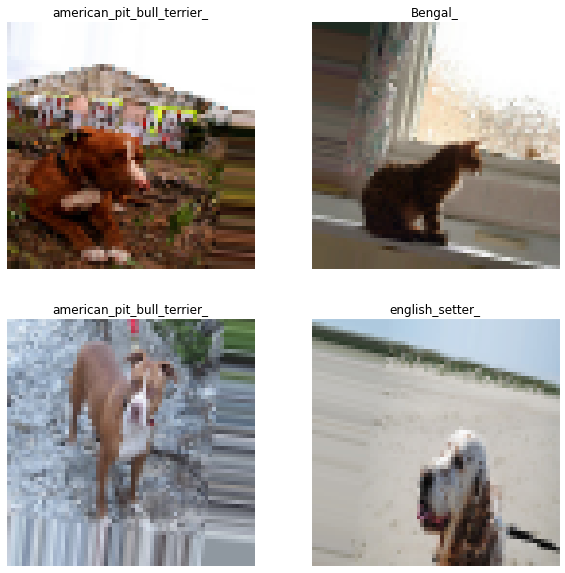

In [24]:
augment_size = 20000

rand_idx2 = np.random.randint(train_images.shape[0], size=augment_size)
x_augmented = train_images[rand_idx2].copy()
y_augmented = train_labels[rand_idx2].copy()
x_augmented = image_generator.flow(x_augmented, np.zeros(augment_size), batch_size=augment_size, shuffle=False).next()[0]

# original data + augmented data
aug_train_images = np.concatenate((train_images, x_augmented))
aug_train_labels = np.concatenate((train_labels, y_augmented))

print('Images after Augmentation : ', aug_train_images.shape[0])

assert aug_train_images.shape[0]==train_images.shape[0] + augment_size
assert aug_train_labels.shape[0]==train_labels.shape[0] + augment_size

index = 2500
data_size = aug_train_images.shape[0]
if index>= data_size-4:
    index =data_size-4
fig = plt.figure()
fig.set_size_inches(10, 10, forward=True)
rows=2
cols=2
print(aug_train_images[index].shape)
for i in range(4):
    ax = fig.add_subplot(rows,cols,i+1)
    ax.imshow((aug_train_images[index+i]*255).astype('uint8'))
    ax.set_title(aug_train_labels[index+i])
    ax.axis("off")

In [25]:
from sklearn.preprocessing import OneHotEncoder
enc= OneHotEncoder()
train_labels_new = aug_train_labels.reshape(-1,1)
enc.fit(train_labels_new)

#changed the names through one-hot encoding.
aug_train_labels_onehot = np.array(enc.transform(train_labels_new).toarray())

print("one-hot encoding train shape is ",aug_train_labels_onehot.shape)
print(aug_train_labels_onehot)

one-hot encoding train shape is  (22500, 25)
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


### My Layer

In [8]:
from keras import layers
from keras import models
import tensorflow as tf

with tf.device('/gpu:0'):
    characters = 25
    jw_model = models.Sequential()
    
    jw_model.add(layers.Conv2D(filters=32, kernel_size=3, padding='same', input_shape=(64,64,3)))
    jw_model.add(layers.BatchNormalization())
    jw_model.add(layers.Activation('relu'))
    jw_model.add(layers.Conv2D(filters=32, kernel_size=3, padding='same'))
    jw_model.add(layers.BatchNormalization())
    jw_model.add(layers.Activation('relu'))
    jw_model.add(layers.MaxPooling2D(pool_size=2))
    jw_model.add(layers.Conv2D(32, (3, 3), strides = (1,1), padding = 'same', kernel_initializer='he_normal'))
    jw_model.add(layers.BatchNormalization())
    jw_model.add(layers.Dropout(rate=0.3))

    jw_model.add(layers.Conv2D(filters=64, kernel_size=3, padding='same'))
    jw_model.add(layers.BatchNormalization())
    jw_model.add(layers.Activation('relu'))
    jw_model.add(layers.Conv2D(filters=64, kernel_size=3, padding='same'))
    jw_model.add(layers.BatchNormalization())
    jw_model.add(layers.Activation('relu'))
    jw_model.add(layers.MaxPooling2D(pool_size=2))
    jw_model.add(layers.Conv2D(64, (3, 3), strides = (1,1), padding = 'same', kernel_initializer='he_normal'))
    jw_model.add(layers.BatchNormalization())
    jw_model.add(layers.Dropout(rate=0.4))

    jw_model.add(layers.Conv2D(filters=128, kernel_size=3, padding='same'))
    jw_model.add(layers.BatchNormalization())
    jw_model.add(layers.Activation('relu'))
    jw_model.add(layers.Conv2D(filters=128, kernel_size=3, padding='same'))
    jw_model.add(layers.BatchNormalization())
    jw_model.add(layers.Activation('relu'))
    jw_model.add(layers.MaxPooling2D(pool_size=2))
    jw_model.add(layers.Conv2D(128, (3, 3), strides = (1,1), padding = 'same', kernel_initializer='he_normal'))
    jw_model.add(layers.BatchNormalization())
    jw_model.add(layers.Dropout(rate=0.5))

    jw_model.add(layers.Conv2D(filters=256, kernel_size=3, padding='same'))
    jw_model.add(layers.BatchNormalization())
    jw_model.add(layers.Activation('relu'))
    jw_model.add(layers.Conv2D(256, (3, 3), strides = (1,1), padding = 'same', kernel_initializer='he_normal'))
    jw_model.add(layers.Conv2D(filters=256, kernel_size=3, padding='same'))
    jw_model.add(layers.BatchNormalization())
    jw_model.add(layers.Activation('relu'))
    jw_model.add(layers.MaxPooling2D(pool_size=2))
    jw_model.add(layers.Conv2D(256, (3, 3), strides = (1,1), padding = 'same', kernel_initializer='he_normal'))
    jw_model.add(layers.BatchNormalization())
    jw_model.add(layers.Dropout(rate=0.5))
    
    jw_model.add(layers.Conv2D(filters=512, kernel_size=3, padding='same'))
    jw_model.add(layers.BatchNormalization())
    jw_model.add(layers.Activation('relu'))
    jw_model.add(layers.Conv2D(filters=512, kernel_size=3, padding='same'))
    jw_model.add(layers.BatchNormalization())
    jw_model.add(layers.Activation('relu'))
    jw_model.add(layers.MaxPooling2D(pool_size=2))
    jw_model.add(layers.Conv2D(512, (3, 3), strides = (1,1), padding = 'same', kernel_initializer='he_normal'))
    jw_model.add(layers.BatchNormalization())
    jw_model.add(layers.Dropout(rate=0.5))
    
    jw_model.add(layers.Flatten())
    jw_model.add(layers.Dense(units=2048))
    jw_model.add(layers.BatchNormalization())
    jw_model.add(layers.Activation('relu'))
    jw_model.add(layers.Dropout(rate=0.5))
    jw_model.add(layers.Dense(units=characters, activation='softmax'))
    
    jw_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 64, 64, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 64, 64, 32)       128       
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 64, 64, 32)        0

                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 2048)              4196352   
                                                                 
 batch_normalization_15 (Bat  (None, 2048)             8192      
 chNormalization)                                                
                                                                 
 activation_10 (Activation)  (None, 2048)              0         
                                                                 
 dropout_5 (Dropout)         (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 25)                51225     
                                                                 
Total params: 12,713,625
Trainable params: 12,703,577
Non-trainable params: 

In [10]:
with tf.device('/gpu:0'):
    jw_model.compile(optimizer='SGD',
                loss='categorical_crossentropy',
                metrics=['accuracy'],
                )
    batch_size = 8

    history=jw_model.fit(aug_train_images, aug_train_labels_onehot, batch_size=batch_size, epochs=100, verbose=1, validation_split=0.1)

Epoch 1/100
2532/2532 [==============================] - 44s 17ms/step - loss: 3.4785 - accuracy: 0.1119 - val_loss: 3.4586 - val_accuracy: 0.1218
Epoch 2/100
2532/2532 [==============================] - 43s 17ms/step - loss: 3.2546 - accuracy: 0.1354 - val_loss: 3.1908 - val_accuracy: 0.1160
Epoch 3/100
2532/2532 [==============================] - 43s 17ms/step - loss: 3.0061 - accuracy: 0.1679 - val_loss: 2.7679 - val_accuracy: 0.1849
Epoch 4/100
2532/2532 [==============================] - 43s 17ms/step - loss: 2.8060 - accuracy: 0.1978 - val_loss: 4.3722 - val_accuracy: 0.1298
Epoch 5/100
2532/2532 [==============================] - 43s 17ms/step - loss: 2.6099 - accuracy: 0.2396 - val_loss: 2.7273 - val_accuracy: 0.2880
Epoch 6/100
2532/2532 [==============================] - 43s 17ms/step - loss: 2.4424 - accuracy: 0.2788 - val_loss: 4.3070 - val_accuracy: 0.2222
Epoch 7/100
2532/2532 [==============================] - 43s 17ms/step - loss: 2.2938 - accuracy: 0.3126 - val_loss: 2

2532/2532 [==============================] - 43s 17ms/step - loss: 0.1371 - accuracy: 0.9557 - val_loss: 0.8919 - val_accuracy: 0.7973
Epoch 57/100
2532/2532 [==============================] - 43s 17ms/step - loss: 0.1355 - accuracy: 0.9576 - val_loss: 0.2173 - val_accuracy: 0.9373
Epoch 58/100
2532/2532 [==============================] - 43s 17ms/step - loss: 0.1209 - accuracy: 0.9612 - val_loss: 0.2391 - val_accuracy: 0.9347
Epoch 59/100
2532/2532 [==============================] - 43s 17ms/step - loss: 0.1180 - accuracy: 0.9635 - val_loss: 0.1959 - val_accuracy: 0.9511
Epoch 60/100
2532/2532 [==============================] - 43s 17ms/step - loss: 0.1162 - accuracy: 0.9624 - val_loss: 0.2486 - val_accuracy: 0.9387
Epoch 61/100
2532/2532 [==============================] - 43s 17ms/step - loss: 0.1181 - accuracy: 0.9633 - val_loss: 0.2209 - val_accuracy: 0.9391
Epoch 62/100
2532/2532 [==============================] - 43s 17ms/step - loss: 0.1159 - accuracy: 0.9618 - val_loss: 0.1716 

In [ ]:
with tf.device('/gpu:0'):
    predictions = jw_model.predict(validation_images)
    decoded_predictions_train = enc.inverse_transform(predictions)

In [11]:
import tensorflow as tf

#saved_model이라는 이름으로 해당 모델을 저장한다.
jw_model.save("./saved_model")

INFO:tensorflow:Assets written to: ./saved_model\assets


In [ ]:
from tensorflow import keras

reconstructed_model = keras.models.load_model("./saved_model")

with tf.device('/gpu:0'):
    validation_score = reconstructed_model.evaluate(validation_images, validation_labels_onehot, verbose=0)

print('test loss : ', validation_score[0])
print('test accuracy : ', validation_score[1])

### 제출간 안내사항
완성된 모델은 아래의 코드를 돌려서 결과를 확인할 겁니다. 지금 상태에서 돌리더라도 train 데이터에 대해서, 확인이 가능할 겁니다. 저희가 평가할 때는 
함수의 첫 번째 인자를 **"imageData"**에서 **"test"**로 바꿔서 확인할겁니다.
코드 제출양식은 아래와 같이 구성된 Pet폴더를 압축해서 주세요. 


Pet
> L MiniProject#1.ipynb

> L saved_model

###※(주의) saved_model은 본인이 최종적으로 학습시킨 모델이어야합니다. 해당 모델은 저희가 평가할것입니다. 폴더 이름은 무조건 saved_model로 할것. (이거 안지키면 감점입니다)

In [ ]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from tensorflow import keras
from keras import models
import tensorflow as tf
from google.colab import drive
import os
import random

def test_accuracy(dataset, model_name):
    #구글드라이브 연결 
    drive.mount('/content/drive/')

    #이미 현재 경로가 설정되있다면
    if os.getcwd() != '/content/drive/My Drive':
        os.chdir('./drive/My Drive')
    print(os.getcwd())
    #원핫인코딩 설정
    origin_labels = np.array([0,1,2])

    if os.path.isfile("./train_label.npy"):#Pet폴더에 없는경우
        origin_labels = np.load("./train_label.npy")
    else : # Pet폴더에 있는경우
        origin_labels = np.load("./Pet/imageDataLabel_25.npy")
    enc= OneHotEncoder()
    origin_labels = origin_labels.reshape(-1,1)
    enc.fit(origin_labels)

    images = np.load("./Pet/"+dataset+"_25.npy")
    labels = np.load("./Pet/"+dataset+"Label_25.npy")

    #이미지 전처리
    images = images / 255.0

    #원핫 인코딩
    labels_new = labels.reshape(-1,1)
    labels_onehot = np.array(enc.transform(labels_new).toarray())
    # print(labels_onehot)
    #저장된 모델을 불러옴
    reconstructed_model = keras.models.load_model("./Pet/"+model_name)
    with tf.device('/gpu:0'):
        score = reconstructed_model.evaluate(images, labels_onehot, verbose=0)
        predictions = reconstructed_model.predict(images)
        decoded_predictions_train = enc.inverse_transform(predictions)

    print('Test loss:', score[0])
    print('Test accuracy:', score[1])

#첫 번째 인자를 수정하세요.
test_accuracy(dataset="test",model_name="saved_model")

## Extra Network

### Dense Net
Reference : https://www.kaggle.com/code/sohaibanwaar1203/dense-net-image-classification/notebook

In [18]:
import keras
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Dense, Input, Activation, Dropout, GlobalAveragePooling2D, BatchNormalization, concatenate, AveragePooling2D
# from keras.optimizers import Adam

def conv_layer(conv_x, filters):
    conv_x = BatchNormalization()(conv_x)
    conv_x = Activation('relu')(conv_x)
    conv_x = Conv2D(filters, (3, 3), kernel_initializer='he_uniform', padding='same', use_bias=False)(conv_x)
    conv_x = Dropout(0.2)(conv_x)

    return conv_x

def dense_block(block_x, filters, growth_rate, layers_in_block):
    for i in range(layers_in_block):
        each_layer = conv_layer(block_x, growth_rate)
        block_x = concatenate([block_x, each_layer], axis=-1)
        filters += growth_rate

    return block_x, filters

def transition_block(trans_x, tran_filters):
    trans_x = BatchNormalization()(trans_x)
    trans_x = Activation('relu')(trans_x)
    trans_x = Conv2D(tran_filters, (1, 1), kernel_initializer='he_uniform', padding='same', use_bias=False)(trans_x)
    trans_x = AveragePooling2D((2, 2), strides=(2, 2))(trans_x)

    return trans_x, tran_filters

def dense_net(filters, growth_rate, classes, dense_block_size, layers_in_block):
    input_img = Input(shape=(64, 64, 3))
    x = Conv2D(24, (3, 3), kernel_initializer='he_uniform', padding='same', use_bias=False)(input_img)

    dense_x = BatchNormalization()(x)
    dense_x = Activation('relu')(x)

    dense_x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(dense_x)
    for block in range(dense_block_size - 1):
        dense_x, filters = dense_block(dense_x, filters, growth_rate, layers_in_block)
        dense_x, filters = transition_block(dense_x, filters)

    dense_x, filters = dense_block(dense_x, filters, growth_rate, layers_in_block)
    dense_x = BatchNormalization()(dense_x)
    dense_x = Activation('relu')(dense_x)
    dense_x = GlobalAveragePooling2D()(dense_x)

    output = Dense(classes, activation='softmax')(dense_x)

    return Model(input_img, output)

dense_block_size = 3
layers_in_block = 4

growth_rate = 12
classes = 25
d_model = dense_net(growth_rate * 2, growth_rate, classes, dense_block_size, layers_in_block)
d_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d_66 (Conv2D)             (None, 64, 64, 24)   648         ['input_1[0][0]']                
                                                                                                  
 activation_57 (Activation)     (None, 64, 64, 24)   0           ['conv2d_66[0][0]']              
                                                                                                  
 max_pooling2d_6 (MaxPooling2D)  (None, 32, 32, 24)  0           ['activation_57[0][0]']          
                                                                                            

                                                                                                  
 activation_64 (Activation)     (None, 16, 16, 84)   0           ['batch_normalization_73[0][0]'] 
                                                                                                  
 conv2d_73 (Conv2D)             (None, 16, 16, 12)   9072        ['activation_64[0][0]']          
                                                                                                  
 dropout_11 (Dropout)           (None, 16, 16, 12)   0           ['conv2d_73[0][0]']              
                                                                                                  
 concatenate_5 (Concatenate)    (None, 16, 16, 96)   0           ['concatenate_4[0][0]',          
                                                                  'dropout_11[0][0]']             
                                                                                                  
 batch_nor

 activation_71 (Activation)     (None, 8, 8, 156)    0           ['batch_normalization_80[0][0]'] 
                                                                                                  
 conv2d_80 (Conv2D)             (None, 8, 8, 12)     16848       ['activation_71[0][0]']          
                                                                                                  
 dropout_17 (Dropout)           (None, 8, 8, 12)     0           ['conv2d_80[0][0]']              
                                                                                                  
 concatenate_11 (Concatenate)   (None, 8, 8, 168)    0           ['concatenate_10[0][0]',         
                                                                  'dropout_17[0][0]']             
                                                                                                  
 batch_normalization_81 (BatchN  (None, 8, 8, 168)   672         ['concatenate_11[0][0]']         
 ormalizat

In [ ]:
with tf.device('/gpu:0'):
    d_model.compile(optimizer='SGD',
                loss='categorical_crossentropy',
                metrics=['accuracy'],
                )
    batch_size =8

    history=d_model.fit(aug_train_images, aug_train_labels_onehot, batch_size=batch_size, epochs=200, verbose=1)

In [ ]:
import tensorflow as tf

#saved_model이라는 이름으로 해당 모델을 저장한다.
d_model.save("./saved_model_dense")

In [ ]:
from tensorflow import keras

reconstructed_model = keras.models.load_model("./saved_model_dense")

with tf.device('/gpu:0'):
    validation_score = reconstructed_model.evaluate(validation_images, validation_labels_onehot, verbose=0)

print('test loss : ', validation_score[0])
print('test accuracy : ', validation_score[1])

### ResNet 50
Reference : https://eremo2002.tistory.com/76

In [12]:
from keras.layers import BatchNormalization, Conv2D, Activation, Dense, GlobalAveragePooling2D, MaxPooling2D, ZeroPadding2D, Add

def conv1_layer(x):    
    x = ZeroPadding2D(padding=(3, 3))(x)
    x = Conv2D(64, (7, 7), strides=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = ZeroPadding2D(padding=(1,1))(x)

    return x   

def conv2_layer(x):         
    x = MaxPooling2D((3, 3), 2)(x)     

    shortcut = x

    for i in range(3):
        if (i == 0):
            x = Conv2D(64, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            x = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            x = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(x)
            shortcut = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(shortcut)            
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)

            x = Add()([x, shortcut])
            x = Activation('relu')(x)

            shortcut = x

    else:
        x = Conv2D(64, (1, 1), strides=(1, 1), padding='valid')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

        x = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

        x = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(x)
        x = BatchNormalization()(x)            

        x = Add()([x, shortcut])   
        x = Activation('relu')(x)  

        shortcut = x        
    return x

def conv3_layer(x):        
    shortcut = x    
    for i in range(4):     
        if(i == 0):            
            x = Conv2D(128, (1, 1), strides=(2, 2), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)        
            
            x = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)  
 
            x = Conv2D(512, (1, 1), strides=(1, 1), padding='valid')(x)
            shortcut = Conv2D(512, (1, 1), strides=(2, 2), padding='valid')(shortcut)
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)            
 
            x = Add()([x, shortcut])    
            x = Activation('relu')(x)    
 
            shortcut = x              
        
        else:
            x = Conv2D(128, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(512, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)            
 
            x = Add()([x, shortcut])     
            x = Activation('relu')(x)
 
            shortcut = x      
    return x

def conv4_layer(x):
    shortcut = x        
  
    for i in range(6):     
        if(i == 0):            
            x = Conv2D(256, (1, 1), strides=(2, 2), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)        
            
            x = Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)  
 
            x = Conv2D(1024, (1, 1), strides=(1, 1), padding='valid')(x)
            shortcut = Conv2D(1024, (1, 1), strides=(2, 2), padding='valid')(shortcut)
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)
 
            x = Add()([x, shortcut]) 
            x = Activation('relu')(x)
 
            shortcut = x               
        
        else:
            x = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(1024, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)            
 
            x = Add()([x, shortcut])    
            x = Activation('relu')(x)
 
            shortcut = x      
    return x
 

def conv5_layer(x):
    shortcut = x    
  
    for i in range(3):     
        if(i == 0):            
            x = Conv2D(512, (1, 1), strides=(2, 2), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)        
            
            x = Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)  
 
            x = Conv2D(2048, (1, 1), strides=(1, 1), padding='valid')(x)
            shortcut = Conv2D(2048, (1, 1), strides=(2, 2), padding='valid')(shortcut)
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)            
 
            x = Add()([x, shortcut])  
            x = Activation('relu')(x)      
 
            shortcut = x               
        
        else:
            x = Conv2D(512, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(2048, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)           
            
            x = Add()([x, shortcut]) 
            x = Activation('relu')(x)       
 
            shortcut = x                  
 
    return x

In [13]:
from keras import Input

input_tensor = Input(shape=(64, 64, 3), dtype='float32', name='input')

x = conv1_layer(input_tensor)
x = conv2_layer(x)
x = conv3_layer(x)
x = conv4_layer(x)
x = conv5_layer(x)

x = layers.GlobalAveragePooling2D()(x)
output_tensor = Dense(25, activation='softmax')(x)

In [14]:
resnet50 = models.Model(input_tensor, output_tensor)
resnet50.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 70, 70, 3)   0           ['input[0][0]']                  
                                                                                                  
 conv2d_16 (Conv2D)             (None, 32, 32, 64)   9472        ['zero_padding2d[0][0]']         
                                                                                                  
 batch_normalization_16 (BatchN  (None, 32, 32, 64)  256         ['conv2d_16[0][0]']              
 ormalization)                                                                                

                                                                                                  
 activation_19 (Activation)     (None, 8, 8, 128)    0           ['batch_normalization_25[0][0]'] 
                                                                                                  
 conv2d_26 (Conv2D)             (None, 8, 8, 512)    66048       ['activation_19[0][0]']          
                                                                                                  
 conv2d_27 (Conv2D)             (None, 8, 8, 512)    131584      ['activation_17[0][0]']          
                                                                                                  
 batch_normalization_26 (BatchN  (None, 8, 8, 512)   2048        ['conv2d_26[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_nor

 ormalization)                                                                                    
                                                                                                  
 add_5 (Add)                    (None, 8, 8, 512)    0           ['batch_normalization_36[0][0]', 
                                                                  'activation_26[0][0]']          
                                                                                                  
 activation_29 (Activation)     (None, 8, 8, 512)    0           ['add_5[0][0]']                  
                                                                                                  
 conv2d_37 (Conv2D)             (None, 4, 4, 256)    131328      ['activation_29[0][0]']          
                                                                                                  
 batch_normalization_37 (BatchN  (None, 4, 4, 256)   1024        ['conv2d_37[0][0]']              
 ormalizat

                                                                                                  
 conv2d_47 (Conv2D)             (None, 4, 4, 256)    262400      ['activation_38[0][0]']          
                                                                                                  
 batch_normalization_47 (BatchN  (None, 4, 4, 256)   1024        ['conv2d_47[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_39 (Activation)     (None, 4, 4, 256)    0           ['batch_normalization_47[0][0]'] 
                                                                                                  
 conv2d_48 (Conv2D)             (None, 4, 4, 256)    590080      ['activation_39[0][0]']          
                                                                                                  
 batch_nor

 ormalization)                                                                                    
                                                                                                  
 activation_49 (Activation)     (None, 2, 2, 512)    0           ['batch_normalization_57[0][0]'] 
                                                                                                  
 conv2d_58 (Conv2D)             (None, 2, 2, 2048)   1050624     ['activation_49[0][0]']          
                                                                                                  
 conv2d_59 (Conv2D)             (None, 2, 2, 2048)   2099200     ['activation_47[0][0]']          
                                                                                                  
 batch_normalization_58 (BatchN  (None, 2, 2, 2048)  8192        ['conv2d_58[0][0]']              
 ormalization)                                                                                    
          

In [ ]:
with tf.device('/gpu:0'):
    resnet50.compile(optimizer='SGD',
                loss='categorical_crossentropy',
                metrics=['accuracy'],
                )
    batch_size = 8 

    history=resnet50.fit(aug_train_images, aug_train_labels_onehot, batch_size=batch_size, epochs=100, verbose=1)

In [ ]:
import tensorflow as tf

#saved_model이라는 이름으로 해당 모델을 저장한다.
resnet50.save("./saved_model_Resnet50")

In [ ]:
from tensorflow import keras

reconstructed_model = keras.models.load_model("./saved_model_Resnet50")

with tf.device('/gpu:0'):
    validation_score = reconstructed_model.evaluate(validation_images, validation_labels_onehot, verbose=0)

print('test loss : ', validation_score[0])
print('test accuracy : ', validation_score[1])